In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsRegressor
from copy import deepcopy
from math import sqrt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
derivation_cohort = pd.read_csv("data/Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("data/External_validation_dataset.csv")

In [3]:
derivation_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,78.0,116.0,94.0,107.0,7.0,107.0,79.0,163.0,142.0,...,46.0,0.0,-61.0,63.0,132.0,201.0,319.0,125.0,59.0,-65.0
1,0,84.0,71.0,174.0,136.0,53.0,NaN,51.0,137.0,113.0,...,69.0,51.0,32.0,-72.0,344.0,742.0,668.0,172.0,-153.0,23.0
2,0,76.0,73.0,191.0,110.0,-72.0,56.0,110.0,153.0,147.0,...,50.0,-131.0,29.0,103.0,-50.0,81.0,186.0,155.0,101.0,60.0
3,0,53.0,76.0,134.0,97.0,71.0,58.0,117.0,50.0,78.0,...,195.0,-249.0,-38.0,266.0,-101.0,89.0,450.0,545.0,656.0,272.0
4,0,34.0,76.0,160.0,87.0,43.0,70.0,26.0,45.0,38.0,...,169.0,-150.0,-59.0,199.0,75.0,192.0,128.0,103.0,127.0,150.0


In [4]:
external_validation_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,64,98,NaN,128,35,14.0,-108,23.0,82.0,...,-105,-176,151,80,-242,-129,-98,272,307,270
1,1,64,76,166.0,95,3,98.0,111,56.0,83.0,...,136,77,-129,143,198,386,469,-147,-140,-106
2,0,55,65,NaN,125,-77,63.0,76,137.0,134.0,...,138,-166,21,186,-159,178,186,144,107,85
3,0,58,67,248.0,79,79,44.0,28,32.0,38.0,...,48,-102,-22,84,-33,89,205,179,115,58
4,0,40,111,140.0,103,54,-22.0,-179,27.0,17.0,...,-108,-51,112,-8,-53,29,87,129,-77,-62


In [9]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_val = external_validation_cohort['Outcome_Occlusion_MI']
X_val = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train=imputer.fit_transform(X_train)
X_test=imputer.fit_transform(X_test)
X_val=imputer.fit_transform(X_val)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
X_val=pd.DataFrame(X_val)

In [10]:
columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

In [11]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'RF (AUC = %0.2f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def results(pred_probas):
    OMI_score = np.round_(pred_probas*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [13]:
def plot_Shapley(clf, df_test, cols, set_name, nf): #nf = number of features
    #Load JS visualization code to notebook
    shap.initjs()
    
    #Shapley explainability
    plt.figure()
    df = pd.DataFrame(data=df_test, columns=(cols))
    
    shap_values_list = []
    for calibrated_classifier in clf.calibrated_classifiers_:
        explainer = shap.TreeExplainer(calibrated_classifier.base_estimator)
        shap_values = explainer.shap_values(df)
        shap_values_list.append(shap_values)
    shap_values = np.array(shap_values_list).sum(axis=0) / len(shap_values_list)
    
    shap.summary_plot(shap_values[1], features=df, feature_names=np.array(cols), sort=True, show=False, max_display=nf, color_bar=False, plot_type='dot', plot_size=(5.00, 10.00))
    plt.title('Shapley values of the top '+str(nf)+'/'+str(len(cols))+' features for OMI prediction (derivation cohort)', fontweight="bold")
    plt.show()

Text(0.5, 1.0, 'Error Rate vs K')

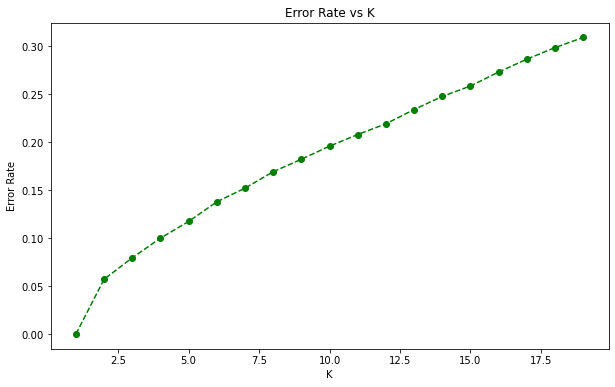

In [17]:
error_rate=[]
for n_neighbors in range (1,20):
    knn_model = KNeighborsRegressor(n_neighbors)
    knn_model.fit(X_train, y_train)
    pred_probas_train = knn_model.predict(X_train)
    error_rate.append(np.mean(pred_probas_train!=y_train))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color="green",linestyle="dashed",marker="o")
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.title("Error Rate vs K")



    #fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train)
    #roc_auc = auc(fpr, tpr)
    #print(n_neighbors,roc_auc)
    #plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')


In [23]:
knn_model = KNeighborsRegressor(5)
knn_model.fit(X_train, y_train)
pred_probas_train = knn_model.predict(X_train)
np.mean(pred_probas_train!=y_train)

0.11739130434782609

Train


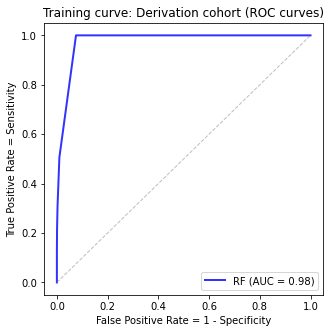

In [24]:
print("Train")
    
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train)
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

In [25]:
risk_groups_train.head()

NameError: name 'risk_groups_train' is not defined

Test


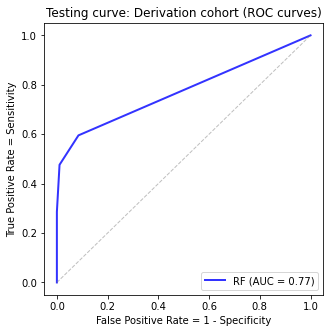

In [26]:
print('Test')
pred_probas_test=knn_model.predict(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test)
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: Derivation cohort (ROC curves)')

#plot_Shapley(knn_model, X_test, columns, 'Derivation cohort', 25)

In [27]:
risk_groups_test.head()

,Low risk,Intermediate risk,High risk
Count (N),716,0,90


External Validation


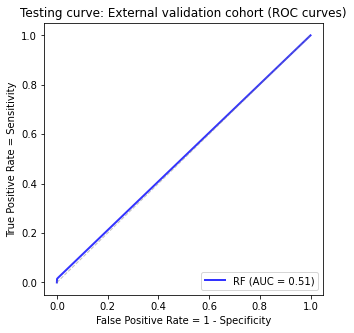

In [28]:
print("External Validation")
pred_probas_val = knn_model.predict(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_val, pred_probas_val)
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: External validation cohort (ROC curves)')

In [51]:
risk_groups_val.head()

,Low risk,Intermediate risk,High risk
Count (N),3274,0,13
